# Cal-CRAI Index: Natural Systems Domain

**Order of operations**:
- Metric handling
   - Retrieve data
   - Outlier handling
   - Min-max standardization
   - Set vulnerability orientation (pos for vulnerable, neg for resilience)
- Calculate indicators
   - Min-max standardization
- Calculate domain score
- Visualizations

Note: Functions and figures within this notebook are in development

In [1]:
import pandas as pd
import os
import sys
import warnings

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.write_metadata import append_metadata
from scripts.utils.index_plot import plot_domain, plot_region_domain
from scripts.utils.calculate_index import (handle_outliers, min_max_standardize, process_domain_csv_files, 
                                        compute_averaged_indicators, compute_summed_indicators, indicator_dicts, 
                                        add_census_tracts, domain_summary_stats)

## Step 1: Metric level
### 1a) Retrieve metric files and process

In [2]:
# set-up
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/'

pull_csv_from_directory(bucket_name, aws_dir, output_folder='aws_csvs', search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/.


In [3]:
# domain-specific
domain_prefix = 'natural_'

input_folder = r'C:/Users/jespi/eagle/carb-climate-index-19/aws_csvs'
output_folder = domain_prefix + "folder"
meta_csv = r'C:/Users/jespi/eagle/carb-climate-index-19/metadata/Full Data Pipeline Notes - 4_ Calculate Metric.csv'
merged_output_file = f'concatenate_{domain_prefix}metrics.csv'

metric_vulnerable_resilient_dict = process_domain_csv_files(domain_prefix, input_folder, output_folder, meta_csv, merged_output_file)

Processed and saved 9 CSV files within natural_ domain.

Metric resilience/vulnerable dictionary created and called: metric_vulnerable_resilient_dict

All entries within the island tract (6075980401) are NaN.

Number of infinite entries in the DataFrame: 0
Replacing infinite entries (if any) with NaN
Number of infinite entries in the DataFrame after replacement: 0

File processing complete, dataframe will now be saved as a .csv
Processed CSV saved as concatenate_natural_metrics.csv


### Take a look at the resulting dictionary
We will use this later to refactor 'resilient' metrics

In [4]:
metric_vulnerable_resilient_dict

{'vulnerable': ['CRI Metric Percentage',
  'esi_mean',
  'ssma_mean',
  'percent_vulnerable_soils',
  'percent_vulnerable_drought',
  'percent_vulnerable_fire',
  'tract_percent_impervious'],
 'resilient': ['protected_areas_percentage', 'SpBioWtEco']}

### Now, take a look at the merged singluar csv file

In [5]:
# read-in and view processed data
processed_natural_df = pd.read_csv('concatenate_natural_metrics.csv')
processed_natural_df

,GEOID,CRI Metric Percentage,protected_areas_percentage,esi_mean,ssma_mean,percent_vulnerable_soils,percent_vulnerable_drought,percent_vulnerable_fire,SpBioWtEco,tract_percent_impervious
0,6001400100,3.664105,17.313634,-0.153958,-0.150978,85.7,94.2,86.1,0.788310,10.386114
1,6001400200,3.664105,NaN,-0.017252,-0.150978,85.7,94.2,86.1,0.585978,53.799769
2,6001400300,3.664105,0.378647,-0.017252,-0.150978,85.7,94.2,86.1,0.434713,68.157336
3,6001400400,3.664105,0.207918,-0.017252,-0.150978,85.7,94.2,86.1,0.547906,59.348445
4,6001400500,3.664105,5.299457,-0.017252,-0.150978,85.7,94.2,86.1,0.471762,65.401895
...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,NaN,0.001260,-0.137129,-0.150281,75.9,76.1,60.4,0.321223,3.337495
9125,6115041001,NaN,0.125437,-0.096554,-0.127511,75.9,76.1,60.4,0.348921,0.657722
9126,6115041002,NaN,27.538314,-0.138815,-0.097916,75.9,76.1,60.4,0.346516,0.415893
9127,6115041101,NaN,43.594855,-0.338232,-0.122181,75.9,76.1,60.4,0.357201,0.216552


### 1b) Handle outliers for each column / metric:
We set a max and min fence based based on each metrics 90th and 10th percentiles with the `handle_outliers` function
* Max fence = 3 x 90th percentile
* Min fence = -3 x 10th percentile

Note: Fencing/outlier handling is not conducted for demographic based metrics (all metrics within vulnerable indicator within Society and Economy domain)

In [6]:
# handle outliers
no_outlier_natural_metrics = handle_outliers(processed_natural_df, domain_prefix, summary_stats=True)

For column CRI Metric Percentage:
  Q1 (10th percentile): 1.4483065953654188
  Q3 (90th percentile): 40.54834054834055
  IQR: 39.10003395297513
  Max fence: 121.64502164502164
  Min fence: -4.3449197860962565
For column protected_areas_percentage:
  Q1 (10th percentile): 0.3516190172705233
  Q3 (90th percentile): 31.097746516279155
  IQR: 30.746127499008633
  Max fence: 93.29323954883746
  Min fence: -1.0548570518115699
For column esi_mean:
  Q1 (10th percentile): -0.5001066
  Q3 (90th percentile): 0.2400836
  IQR: 0.7401902
  Max fence: 0.7202508000000001
  Min fence: 1.5003197999999998
For column ssma_mean:
  Q1 (10th percentile): -0.16486365
  Q3 (90th percentile): -0.065221906
  IQR: 0.099641744
  Max fence: -0.195665718
  Min fence: 0.49459095
For column percent_vulnerable_soils:
  Q1 (10th percentile): 15.6
  Q3 (90th percentile): 82.8
  IQR: 67.2
  Max fence: 248.39999999999998
  Min fence: -46.8
For column percent_vulnerable_drought:
  Q1 (10th percentile): 71.7
  Q3 (90th perc

In [7]:
no_outlier_natural_metrics

,GEOID,CRI Metric Percentage,protected_areas_percentage,esi_mean,ssma_mean,percent_vulnerable_soils,percent_vulnerable_drought,percent_vulnerable_fire,SpBioWtEco,tract_percent_impervious
0,6001400100,3.664105,17.313634,0.720251,-0.150978,85.7,94.2,86.1,0.788310,10.386114
1,6001400200,3.664105,NaN,0.720251,-0.150978,85.7,94.2,86.1,0.585978,53.799769
2,6001400300,3.664105,0.378647,0.720251,-0.150978,85.7,94.2,86.1,0.434713,68.157336
3,6001400400,3.664105,0.207918,0.720251,-0.150978,85.7,94.2,86.1,0.547906,59.348445
4,6001400500,3.664105,5.299457,0.720251,-0.150978,85.7,94.2,86.1,0.471762,65.401895
...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,NaN,0.001260,0.720251,-0.150281,75.9,76.1,60.4,0.321223,3.337495
9125,6115041001,NaN,0.125437,0.720251,-0.127511,75.9,76.1,60.4,0.348921,0.657722
9126,6115041002,NaN,27.538314,0.720251,-0.097916,75.9,76.1,60.4,0.346516,0.415893
9127,6115041101,NaN,43.594855,0.720251,-0.122181,75.9,76.1,60.4,0.357201,0.216552


### 1c) Min-max standardization
Metrics are min-max standardized on 0.01 to 0.99 scale.

In [8]:
# standardizing our df
columns_to_process = [col for col in no_outlier_natural_metrics.columns if col != 'GEOID']
min_max_metrics = min_max_standardize(no_outlier_natural_metrics, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


In [9]:
# this will show the standardized columns as well as their max and min column counterparts used in the process

#min_max_metrics

Isolate for GEOID and standardized columns exclusively

In [9]:
words = ['GEOID','standardized']
selected_columns = []
for word in words:
    selected_columns.extend(min_max_metrics.columns[min_max_metrics.columns.str.contains(word)].tolist())
min_max_standardized_natural_metrics_df = min_max_metrics[selected_columns]

In [10]:
min_max_standardized_natural_metrics_df.head()

,GEOID,CRI Metric Percentage_min_max_standardized,protected_areas_percentage_min_max_standardized,esi_mean_min_max_standardized,ssma_mean_min_max_standardized,percent_vulnerable_soils_min_max_standardized,percent_vulnerable_drought_min_max_standardized,percent_vulnerable_fire_min_max_standardized,SpBioWtEco_min_max_standardized,tract_percent_impervious_min_max_standardized
0,6001400100,0.085712,0.185583,0.0,0.123013,0.926486,0.957403,0.7713,0.813906,0.103861
1,6001400200,0.085712,NaN,0.0,0.123013,0.926486,0.957403,0.7713,0.570893,0.537998
2,6001400300,0.085712,0.004059,0.0,0.123013,0.926486,0.957403,0.7713,0.389214,0.681573
3,6001400400,0.085712,0.002229,0.0,0.123013,0.926486,0.957403,0.7713,0.525166,0.593484
4,6001400500,0.085712,0.056804,0.0,0.123013,0.926486,0.957403,0.7713,0.433712,0.654019


### 1d) Set vulnerability orientation
* High values indicate vulnerability
* Low values indicate resiliency

Some metrics indicate a communities resistance rather than vulnerablity. For example, number of emergency personel per 10,000 people represents a communities ability to respond to emergencies. For this metric, the higher the number, the more resilient. So we identify these 'resilient' metrics with our `metric_vulnerable_resilient_dict` dictionary and subtract their values from 1 so all high values indicate vulnerability

In [11]:
metric_vulnerable_resilient_dict

{'vulnerable': ['CRI Metric Percentage',
  'esi_mean',
  'ssma_mean',
  'percent_vulnerable_soils',
  'percent_vulnerable_drought',
  'percent_vulnerable_fire',
  'tract_percent_impervious'],
 'resilient': ['protected_areas_percentage', 'SpBioWtEco']}

In [12]:
# Access the resilient column names from the dictionary
resilient_columns = metric_vulnerable_resilient_dict['resilient']

# Identify columns in the DataFrame that contain any of the resilient column names as substrings
resilient_columns_in_df = [col for col in min_max_standardized_natural_metrics_df.columns 
                           if any(resilient_col in col for resilient_col in resilient_columns)]

# Create a new DataFrame with the adjusted resilient columns
adjusted_resilient_df = min_max_standardized_natural_metrics_df.copy()

# Subtract the standardized resilient columns from one and store the result in the new DataFrame
adjusted_resilient_df.loc[:, resilient_columns_in_df] = (
    1 - adjusted_resilient_df.loc[:, resilient_columns_in_df]
)

In [13]:
adjusted_resilient_df

,GEOID,CRI Metric Percentage_min_max_standardized,protected_areas_percentage_min_max_standardized,esi_mean_min_max_standardized,ssma_mean_min_max_standardized,percent_vulnerable_soils_min_max_standardized,percent_vulnerable_drought_min_max_standardized,percent_vulnerable_fire_min_max_standardized,SpBioWtEco_min_max_standardized,tract_percent_impervious_min_max_standardized
0,6001400100,0.085712,0.814417,0.0,0.123013,0.926486,0.957403,0.771300,0.186094,0.103861
1,6001400200,0.085712,NaN,0.0,0.123013,0.926486,0.957403,0.771300,0.429107,0.537998
2,6001400300,0.085712,0.995941,0.0,0.123013,0.926486,0.957403,0.771300,0.610786,0.681573
3,6001400400,0.085712,0.997771,0.0,0.123013,0.926486,0.957403,0.771300,0.474834,0.593484
4,6001400500,0.085712,0.943196,0.0,0.123013,0.926486,0.957403,0.771300,0.566288,0.654019
...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,NaN,0.999986,0.0,0.124930,0.820541,0.769351,0.195067,0.747095,0.033375
9125,6115041001,NaN,0.998655,0.0,0.187610,0.820541,0.769351,0.195067,0.713828,0.006577
9126,6115041002,NaN,0.704820,0.0,0.269078,0.820541,0.769351,0.195067,0.716717,0.004159
9127,6115041101,NaN,0.532712,0.0,0.202283,0.820541,0.769351,0.195067,0.703884,0.002166


## Step 2: Calculate Indicators
Loop to go through df columns and average metrics that belong within an indicator based off of the metric to indicator dictionary

In [14]:
domain_prefix[:-1]

'natural'

In [15]:
averaged_indicators_natural_systems = compute_averaged_indicators(
    adjusted_resilient_df, 
    indicator_dicts(domain_prefix[:-1])
)

# show resulting dataframe to highlight the indicator values
averaged_indicators_natural_systems

,GEOID,natural_resource_conservation,agricultural_productivity_conservation,ecosystem_condition
0,6001400100,0.814417,0.061506,0.589029
1,6001400200,NaN,0.061506,0.724459
2,6001400300,0.995941,0.061506,0.789510
3,6001400400,0.997771,0.061506,0.744702
4,6001400500,0.943196,0.061506,0.775099
...,...,...,...,...
9124,6115040902,0.999986,0.062465,0.513086
9125,6115041001,0.998655,0.093805,0.501073
9126,6115041002,0.704820,0.134539,0.501167
9127,6115041101,0.532712,0.101141,0.498202


Sum all the non-census tract columns together to calculate the domain score

In [16]:
columns_to_sum = [col for col in averaged_indicators_natural_systems.columns if col != 'GEOID']
summed_indicators_natural_systems = compute_summed_indicators(
    df=averaged_indicators_natural_systems, 
    columns_to_sum=columns_to_sum,
    domain_prefix=domain_prefix
)

Indicator sum min value: 0.0
Indicator sum max value: 2.653089832995031


### 2a) Min-max standardize the summed columns

In [17]:
columns_to_process = [col for col in summed_indicators_natural_systems.columns if col != 'GEOID']
min_max_domain = min_max_standardize(summed_indicators_natural_systems, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


In [18]:
min_max_domain

,GEOID,summed_indicators_natural_domain_min,summed_indicators_natural_domain_max,summed_indicators_natural_domain_min_max_standardized
0,6001400100,0.0,2.65309,0.552168
1,6001400200,0.0,2.65309,0.296245
2,6001400300,0.0,2.65309,0.696153
3,6001400400,0.0,2.65309,0.679954
4,6001400500,0.0,2.65309,0.670841
...,...,...,...,...
9124,6115040902,0.0,2.65309,0.593850
9125,6115041001,0.0,2.65309,0.600633
9126,6115041002,0.0,2.65309,0.505270
9127,6115041101,0.0,2.65309,0.426693


Isolate to census tract and summed standardized columns, and rename tract to GEOID for merging
* add a zero at the beginning of the GEOID to match census tract that will be merged

In [19]:
min_max_standardized_natural_systems_domain = min_max_domain[['GEOID', 'summed_indicators_natural_domain_min_max_standardized']].copy()

# GEOID handling
min_max_standardized_natural_systems_domain['GEOID'] = min_max_standardized_natural_systems_domain['GEOID'].apply(lambda x: '0' + str(x))
min_max_standardized_natural_systems_domain['GEOID'] = min_max_standardized_natural_systems_domain['GEOID'].astype(str).apply(lambda x: x.rstrip('0').rstrip('.') if '.' in x else x)

## Step 3: Visualizing the domain


Merge the df and census tracts and convert the geometry to our uniformly used coordinate reference system (4269)

In [20]:
gdf = add_census_tracts(min_max_standardized_natural_systems_domain)

In [22]:
gdf.columns

Index(['GEOID', 'summed_indicators_natural_domain_min_max_standardized',
       'STATEFP', 'COUNTYFP', 'TRACTCE', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')

Let's look at some summary statistics for this domain:

In [23]:
domain_summary_stats(gdf, 'summed_indicators_natural_domain_min_max_standardized')

Median summed_indicators_natural_domain_min_max_standardized domain value: 0.5644829567656434
Mean summed_indicators_natural_domain_min_max_standardized domain value: 0.5025286985541961


Now let's visualize the entire domain!

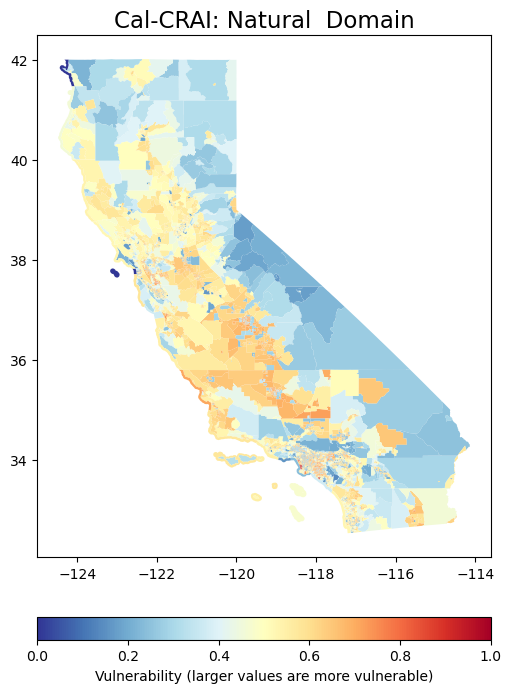

In [24]:
plot_domain(gdf, domain=domain_prefix)

### We can also visualize specific areas!
We call from a the `plot_region_domain` function which has a number of variables:

gdf : GeoDataFrame
    A GeoDataFrame containing the data you want to plot, which must include the column 'GEOID' to match with the census tract data.

counties_to_plot : list of str, optional
    A list of county FIPS codes (as strings) to plot. If None, no counties will be plotted.
    Example: ['037', '071', '065', '029', '111'].

region : str, optional
    A predefined region to plot. Options: 'bay_area', 'central_region', 'inland_deserts', 'north_central', 'northern', or 'south_coast'.
    If specified, this will override `counties_to_plot`.

plot_all : bool, optional
    If True, plots all counties in California. Overrides `counties_to_plot` and `region`.

savefig : bool, optional
    If True, the plot will be saved as a PNG file. Default is False.

font_color : str, optional
    Color of the font for county labels. Default is 'black'.

domain_name : str, optional
    Name of the domain to include in the plot title. Default is 'Society and Economy Domain'.


    Dictionary of county labels
    county_labels = {
        '001': 'Alameda', '003': 'Alpine', '005': 'Amador', '007': 'Butte', '009': 'Calaveras',
        '011': 'Colusa', '013': 'Contra Costa', '015': 'Del Norte', '017': 'El Dorado', '019': 'Fresno',
        '021': 'Glenn', '023': 'Humboldt', '025': 'Imperial', '027': 'Inyo', '029': 'Kern',
        '031': 'Kings', '033': 'Lake', '035': 'Lassen', '037': 'Los Angeles', '039': 'Madera',
        '041': 'Marin', '043': 'Mariposa', '045': 'Mendocino', '047': 'Merced', '049': 'Modoc',
        '051': 'Mono', '053': 'Monterey', '055': 'Napa', '057': 'Nevada', '059': 'Orange',
        '061': 'Placer', '063': 'Plumas', '065': 'Riverside', '067': 'Sacramento', '069': 'San Benito',
        '071': 'San Bernardino', '073': 'San Diego', '075': 'San Francisco', '077': 'San Joaquin',
        '079': 'San Luis Obispo', '081': 'San Mateo', '083': 'Santa Barbara', '085': 'Santa Clara',
        '087': 'Santa Cruz', '089': 'Shasta', '091': 'Sierra', '093': 'Siskiyou', '095': 'Solano',
        '097': 'Sonoma', '099': 'Stanislaus', '101': 'Sutter', '103': 'Tehama', '105': 'Trinity',
        '107': 'Tulare', '109': 'Tuolumne', '111': 'Ventura', '113': 'Yolo', '115': 'Yuba'

You can plot a domains vulnerability index by region, specific county/counties, or the entirety of CA with labels
Below are a few example of each of these plotting scenarios

Number of invalid geometries: 0


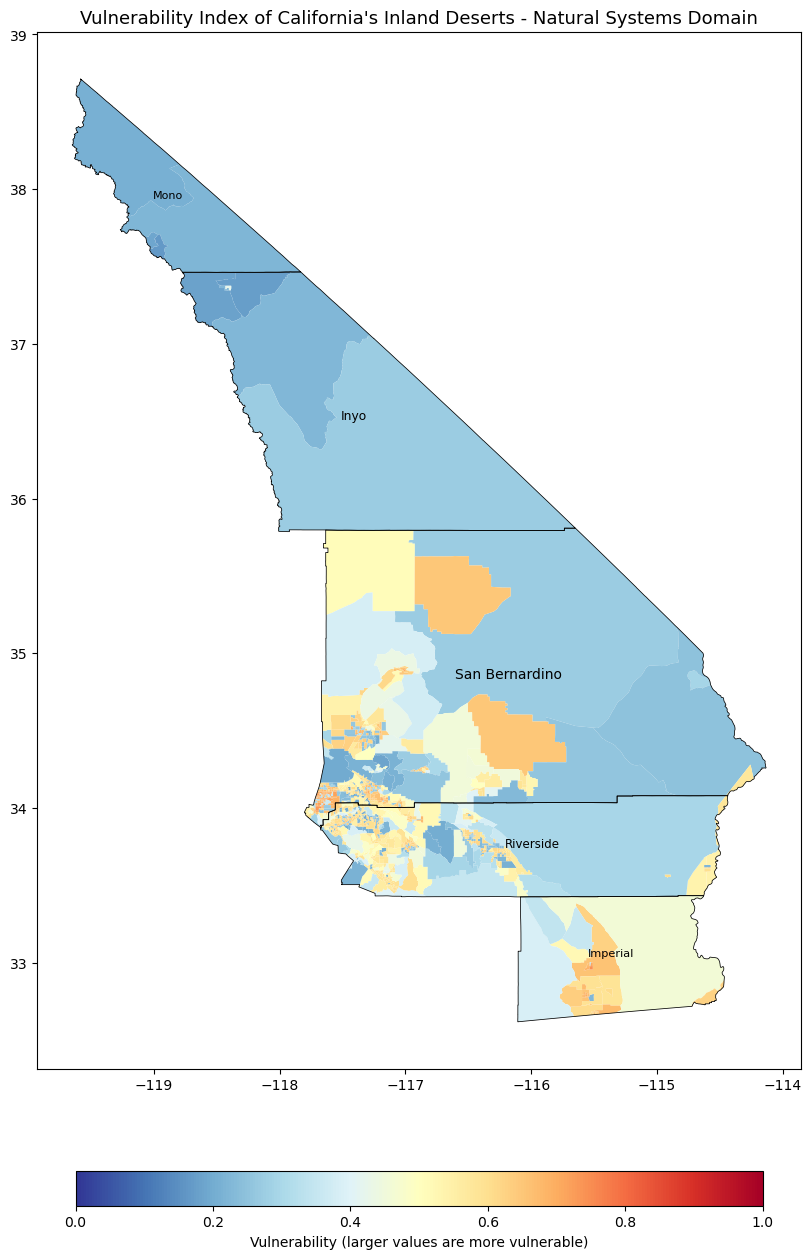

In [26]:
plot_region_domain(min_max_standardized_natural_systems_domain, domain=domain_prefix, domain_label_map={domain_prefix: 'Natural Systems Domain'}, region='inland_deserts', savefig=False, font_color='black')

Number of invalid geometries: 0


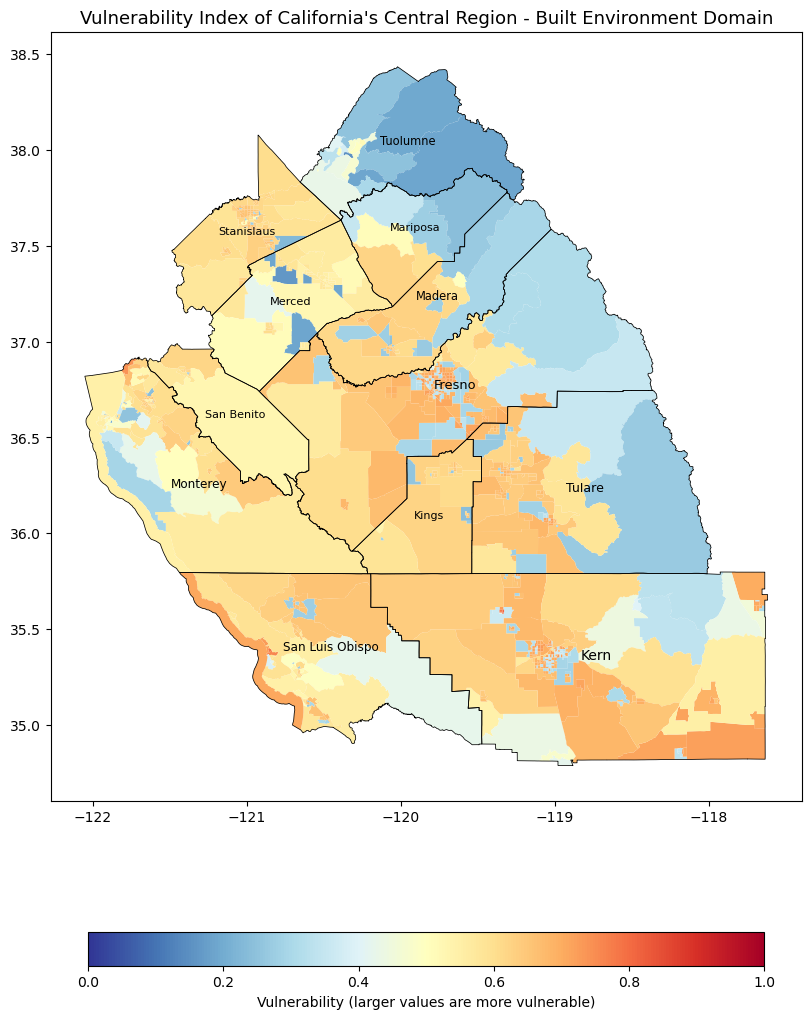

In [27]:
plot_region_domain(min_max_standardized_natural_systems_domain, domain=domain_prefix, domain_label_map={domain_prefix: 'Built Environment Domain'}, region='central_region', savefig=False, font_color='black')

Number of invalid geometries: 0


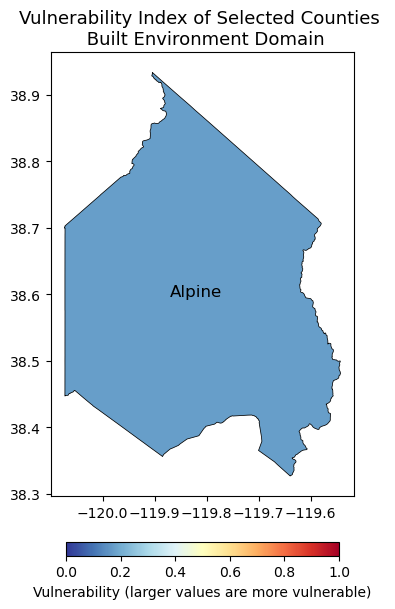

In [28]:
list_of_counties = ['003']
plot_region_domain(min_max_standardized_natural_systems_domain, domain=domain_prefix, domain_label_map={domain_prefix: 'Built Environment Domain'}, counties_to_plot=list_of_counties, savefig=False, font_color='black')

Number of invalid geometries: 0


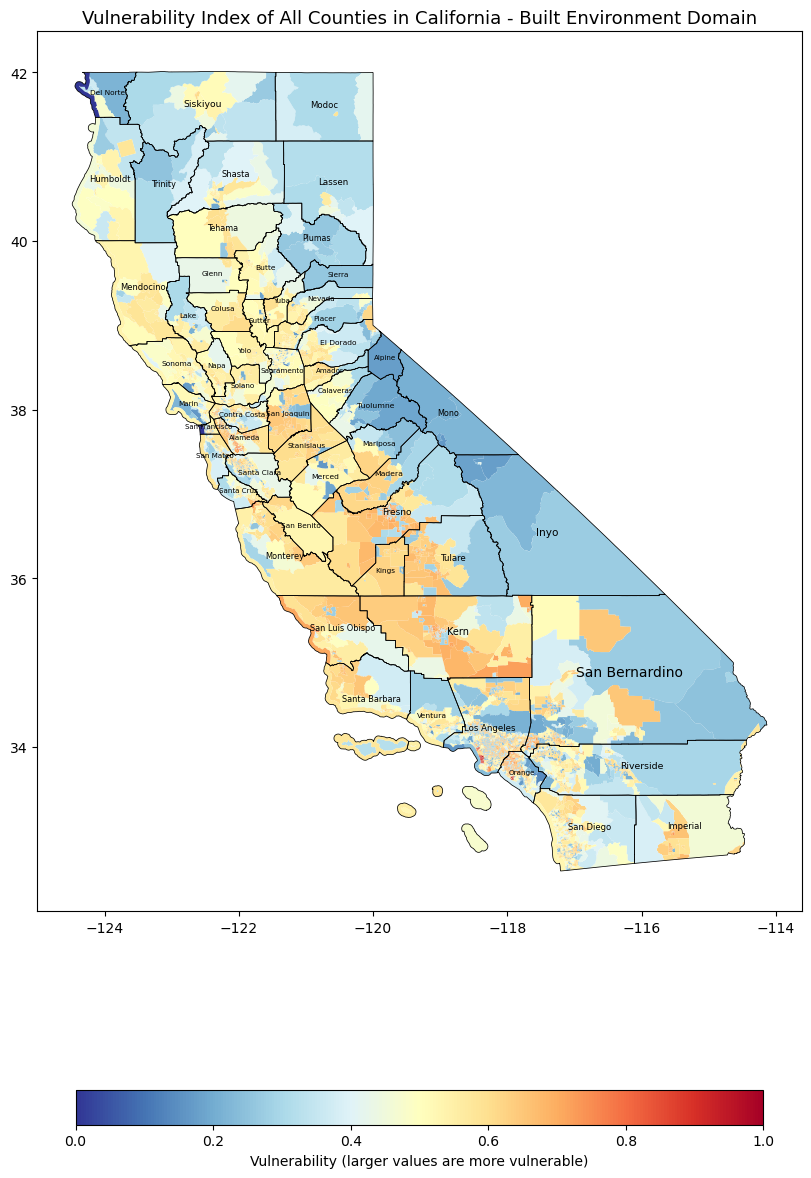

In [29]:
plot_region_domain(min_max_standardized_natural_systems_domain, domain=domain_prefix, domain_label_map={domain_prefix: 'Built Environment Domain'}, plot_all=True, savefig=False, font_color='black')

## Step 4: Export the final domain csv file

In [17]:
# set-up file for export
filename = '{}index_data.csv'.format(domain_prefix)
gdf.to_csv(filename, index=False)

# export to AWS (Cal-CRAI)
directory = '3_fair_data/domain_standardized_data'
upload_csv_aws([filename], bucket_name, directory)